<a href="https://colab.research.google.com/github/RoboMaroof/LLM-Applications-Building-Blocks/blob/main/00_LLM_Concepts/03_LLM_from_scratch_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources

https://www.youtube.com/watch?v=l8pRSuU81PU

https://github.com/karpathy/build-nanogpt/tree/master

GPT2: https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf

GPT3: https://arxiv.org/abs/2005.14165

# Installs and Imports

In [ ]:
!pip install tiktoken
# !pip install hellaswag

In [ ]:
import os
import math
import time
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.distributed import init_process_group, destroy_process_group
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

import tiktoken

# from hellaswag import render_example, iterate_examples

# Language Model Architecture

## Config

In [ ]:
@dataclass
class GPTConfig:
    block_size: int = 1024  # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12       # number of layers
    n_head: int = 12        # number of heads
    n_embd: int = 768       # embedding dimension

## CausalSelfAttention

In [ ]:
class CausalSelfAttention(nn.Module):   # Multi Head Attention

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1  # Flag to identify Residual connection for Initialization step
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, context / sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # nh made into a batchdimension along with B. All operations in following steps applied in parallel in these dimensions
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)

        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        """
        # EQUIVALENT CODE FOR FLASH ATTENTION
        # attention (materializes the large (T,T) matrix for all the queries and keys)
        att = (q @ k.transpose(-2,-1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf')) #for decoder only
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)  | weighted sum of the 'values' of the tokens that was found interesting at every single token
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        """
        # FLASH ATTENTION | online incremental softmax | fused kernel | resuced read/write ops from HBM
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        # https://arxiv.org/abs/2205.14135 | https://arxiv.org/abs/2307.08691 | https://pytorch.org/blog/flashattention-3/ | https://arxiv.org/abs/2407.08608
        y = y.transpose(1, 2).contiguous().view(B, T, C)            # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

## MLP

In [ ]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)  #
        self.gelu    = nn.GELU(approximate='tanh')                  # GELU Paper: https://arxiv.org/abs/1606.08415 | No flat region | approximate='tanh' not required anymore
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1    # Flag to identify Residual connection for Initialization step

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

# x --> linear --> gelu --> linear

## Single Hidden Layer Block

In [ ]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config) # Coomunication | Aggregation function | Pooling function | Weighted sum function | Reduce function
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)                  # Feed Forward Network | Every token think individually about gathered information | Map function

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

# x --> { ln --> s.attn } Residual --> { ln --> mlp } Residual

## Language Model

In [ ]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),               # Wieghts of Token Embeddings
            wpe = nn.Embedding(config.block_size, config.n_embd),               # Wieghts of Position Embeddings
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),  # Hidden layers
            ln_f = nn.LayerNorm(config.n_embd),                                 # Layer Norm
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)  # Language Model head --> Final Classifier

        # weight sharing scheme between token embedding and lm_head
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'): # If Residual connection, to avoid increasing SD due to repeated additions, divide by √Number of residual layers | Number of residual layers = 2 * config.n_layer (1 each in MLP and ATTN) | Glorot (or Xavier) Initialization
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias) # Initialize bias to zero
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        # Only other type of module is LayerNorm. PyTorch by default initializes it with scale=1 and offset=0

    def forward(self, idx, targets=None):
        # idx is of shape (B, T) --> token indices | independent along B | Attention along T
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # position indices of shape (T)
        pos_emb = self.transformer.wpe(pos)                           # position embeddings of shape (T, n_embd) --> identical for every row of B dimension
        tok_emb = self.transformer.wte(idx)                           # token embeddings of shape (B, T, n_embd)

        x = tok_emb + pos_emb                                         # Hidden broadcasting where additional B dimension added to pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)     # (B, T, vocab_size) | for every B x T indices, calculate logits for what token comes next | logits --> softmax --> probilities at (B, T+1) for tokens from vocab_size

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    # x --> pos_emb + tok_emb --> for block in transformer.h --> transformer.ln_f(x) --> lm_head() --> logits --> F.cross_entropy --> loss

    # All weights initialized to random values by default


    def configure_optimizers(self, weight_decay, learning_rate, device_type):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # weight decay is regularization technique |  penalty term on the magnitude of the weights | force the model to distribute work across the channels
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2] # weights in MatMuls and embeddings
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2] # 1D tensors such as biases, layer_norm, scales need not be weight decayed
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        if master_process:
            print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
            print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available | kernel fusion for AdamW optimizer | updates weights in parallel instead of in a for loop
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        if master_process:
            print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused) # AdamW effectively a bug fix for Adam optimizer | hyperparameters: betas, eps
        return optimizer

# Load Tokens

In [ ]:
def load_tokens(filename):
    npt = np.load(filename)
    npt = npt.astype(np.int32)
    ptt = torch.tensor(npt, dtype=torch.long)
    return ptt

# DataLoader Class

In [ ]:
class DataLoaderLite:
    def __init__(self, B, T, process_rank, num_processes, split):
        self.B = B
        self.T = T
        self.process_rank = process_rank
        self.num_processes = num_processes
        assert split in {'train', 'val'}

        # get the shard filenames
        data_root = "edu_fineweb10B"    #
        shards = os.listdir(data_root)
        shards = [s for s in shards if split in s]
        shards = sorted(shards)
        shards = [os.path.join(data_root, s) for s in shards]
        self.shards = shards
        assert len(shards) > 0, f"no shards found for split {split}"
        if master_process:
            print(f"found {len(shards)} shards for split {split}")
        self.reset()

    def reset(self):
        # state, init at shard zero
        self.current_shard = 0
        self.tokens = load_tokens(self.shards[self.current_shard])
        self.current_position = self.B * self.T * self.process_rank # each ddp process takes different data

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]  # buffer tokens in 1D from which tokens and targets are arranged in [B, T]
        x = (buf[:-1]).view(B, T)   # inputs
        y = (buf[1:]).view(B, T)    # targets | T+1 compared to x
        # advance the position in the tensor
        self.current_position += B * T * self.num_processes         # each ddp process takes different data
        # if loading the next batch would be out of bounds, advance to next shard
        if self.current_position + (B * T * self.num_processes + 1) > len(self.tokens):  # Once run out of batches, go back to 0
            self.current_shard = (self.current_shard + 1) % len(self.shards)
            self.tokens = load_tokens(self.shards[self.current_shard])
            self.current_position = B * T * self.process_rank
        return x, y

In [ ]:
def get_most_likely_row(tokens, mask, logits):
    # evaluate the autoregressive loss at all positions
    shift_logits = (logits[..., :-1, :]).contiguous()
    shift_tokens = (tokens[..., 1:]).contiguous()
    flat_shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    flat_shift_tokens = shift_tokens.view(-1)
    shift_losses = F.cross_entropy(flat_shift_logits, flat_shift_tokens, reduction='none')
    shift_losses = shift_losses.view(tokens.size(0), -1)
    # now get the average loss just for the completion region (where mask == 1), in each row
    shift_mask = (mask[..., 1:]).contiguous() # we must shift mask, so we start at the last prompt token
    masked_shift_losses = shift_losses * shift_mask
    # sum and divide by the number of 1s in the mask
    sum_loss = masked_shift_losses.sum(dim=1)
    avg_loss = sum_loss / shift_mask.sum(dim=1)
    # now we have a loss for each of the 4 completions
    # the one with the lowest loss should be the most likely
    pred_norm = avg_loss.argmin().item()
    return pred_norm

# Distributed Data Parallelism (DDP)

With N GPUs, each GPU works on different parts of data and average of the gradients taken.

Forward pass  : Behaves identically
Backward pass : Once the backward pass is over or during the forward pass in each independent GPU, each GPU has the gradient for the parameters. DDP calls `all_reduce` which averages across all the ranks of the gradients and deposit the average in every single rank/gpu

DDP Communication: synchronises and averages the gradients

Run using `torchrun`

Environment variables required for `torchrun`:
* 'RANK'        : RANK of each GPU (-1,0,1,2,3,...) | -1 if DDP not running
* 'LOCAL_RANK'  : RANK of GPU on single node in a multi-node setting
* 'WORLD_SIZE'  : Total number of processes/ GPUs

In [ ]:
# set up DDP (distributed data parallel).
# torchrun command sets the env variables RANK, LOCAL_RANK, and WORLD_SIZE
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    # use of DDP atm demands CUDA, we set the device appropriately according to rank
    assert torch.cuda.is_available(), "for now i think we need CUDA for DDP"
    init_process_group(backend='nccl')
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}' # (0,1,2,3)
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
else:
    # vanilla, non-DDP run
    ddp_rank = 0
    ddp_local_rank = 0
    ddp_world_size = 1
    master_process = True
    # attempt to autodetect device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = "mps"  # For Apple silicon
    print(f"using device: {device}")

# added after video, pytorch can be serious about it's device vs. device_type distinction
device_type = "cuda" if device.startswith("cuda") else "cpu"

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

enc = tiktoken.get_encoding("gpt2")


# Gradient Accumulation

 Simulates in a serial way any set arbitrary batch size, by processing multiple sequences and add up all gradients from them

In [ ]:
total_batch_size = 524288 # 2**19, ~0.5M, in number of tokens
B = 64 # micro batch size
T = 1024 # sequence length
assert total_batch_size % (B * T * ddp_world_size) == 0, "make sure total_batch_size is divisible by B * T * ddp_world_size"
grad_accum_steps = total_batch_size // (B * T * ddp_world_size) # forward-backwards for grad_accum_steps times and gradients are accumulated but weights are not updated till the end
if master_process:
    print(f"total desired batch size: {total_batch_size}")
    print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

# Initialize DataLoaders

In [ ]:
train_loader = DataLoaderLite(B=B, T=T, process_rank=ddp_rank, num_processes=ddp_world_size, split="train")
val_loader = DataLoaderLite(B=B, T=T, process_rank=ddp_rank, num_processes=ddp_world_size, split="val")

torch.set_float32_matmul_precision('high')  # Set the internal precision of float32 matrix multiplications to TF32 | Applicable to all nn.Linear | 3x throughput |  https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf
# 'highest': FP32 | 'high': TF32 | 'medium': bfloat16 | https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html
# 3x (NOT 8x) throughput due to memory constraints as the numbers are still float32 which are being moved around

https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf

**TF32:** internal matmul operations in TF32 but numbers stored in FP32 --> memory constraints

**FP16:** complicated due to truncation of range which necessitates gradient scaling operations

**BF16:** do not need gradient scalers.

**Automatic Mixed Precision** Activations / Logits in bfloat16 but parameters, some layers (such as norms), loss calculations still in float32. https://pytorch.org/docs/stable/amp.html#torch.autocast

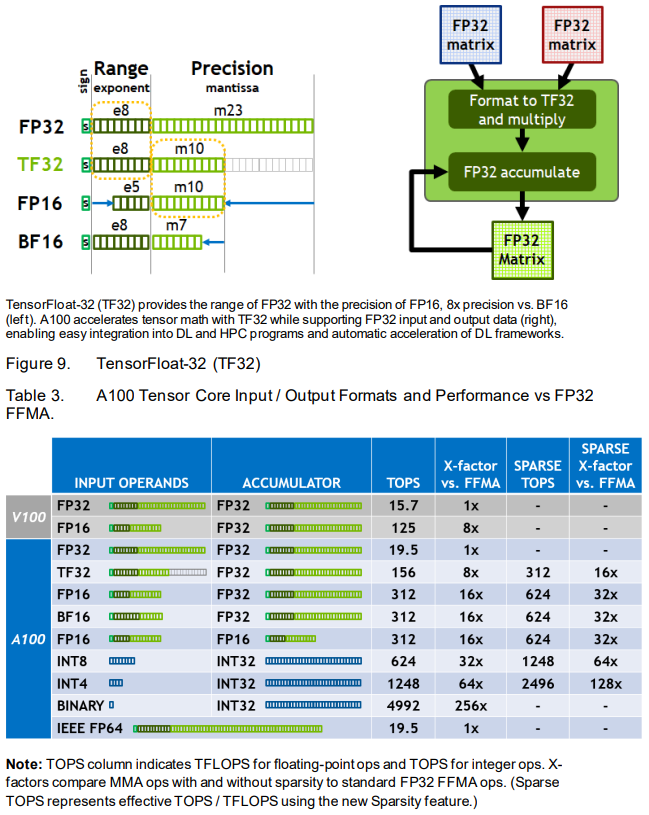

**Automatic Mixed Precision**

https://pytorch.org/docs/stable/amp.html

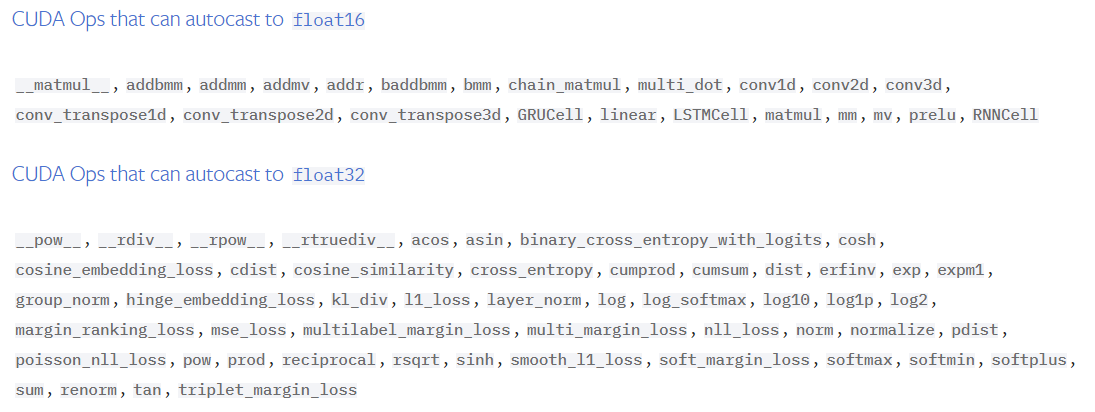

# Model Initialization

In [ ]:
# create model
model = GPT(GPTConfig(vocab_size=50304)) # change vocab_size to power of 2 | adds dummy tokens | increases flops but 4 % reduction in time
model.to(device)
use_compile = False              # torch.compile interferes with HellaSwag eval and Generation. TODO fix
if use_compile:
    model = torch.compile(model) # 7x throughput | increased compile time but reduced read/write ops | No python interpreter in forward pass | https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank]) # wrap the model in ddp container
raw_model = model.module if ddp else model          # always contains the "raw" unwrapped model

# Learning Rate

In [ ]:
max_lr = 6e-4
min_lr = max_lr * 0.1 # 10 % of max_lr
warmup_steps = 715 # calculated from "warmup for 375M tokens"
max_steps = 19073 # 19,073 steps is ~1 epoch, if data is 10B tokens and batch size 0.5M tokens

def get_lr(it): # it=step
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps # it+1 so that lr is not 0 initially
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

## Cosine rate decay

Linear warmup + cosine decay

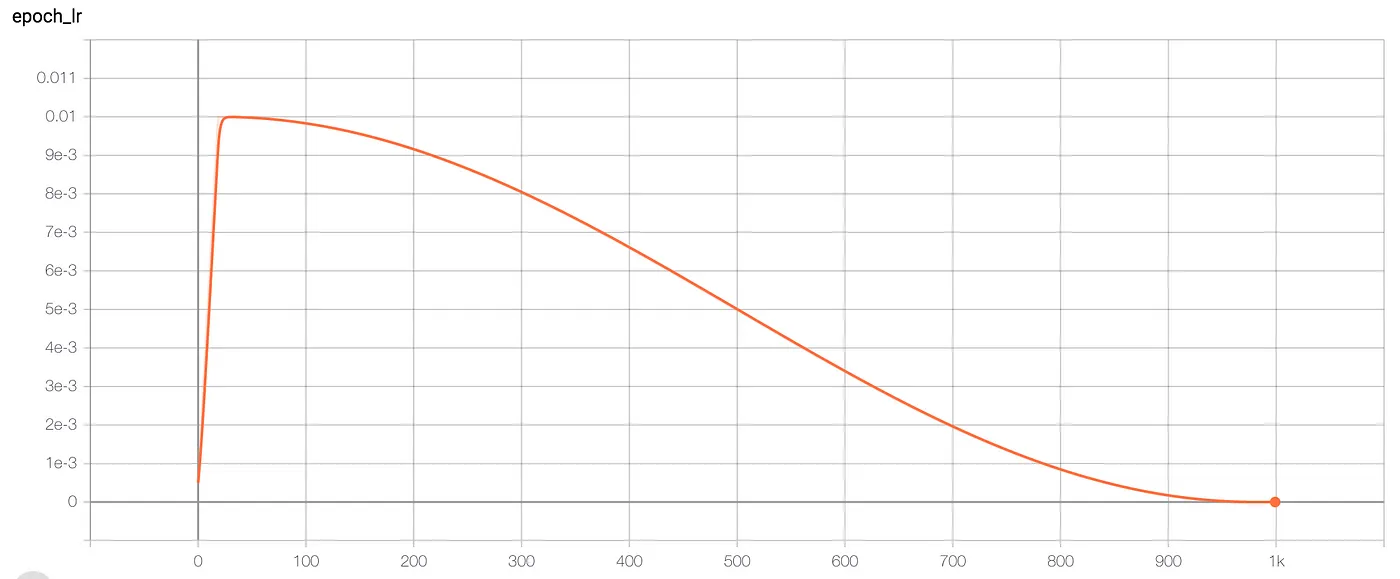

# Optimizer

In [ ]:
optimizer = raw_model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device_type=device_type)

# Log Directory

In [ ]:
# create the log directory we will write checkpoints to and log to
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"log.txt")
with open(log_file, "w") as f: # open for writing to clear the file
    pass

# Training

In [ ]:
for step in range(max_steps):
    t0 = time.time()
    last_step = (step == max_steps - 1)

    #============================================================================================================================================================================#
    # Evaluate validation loss every 250th step
    if step % 250 == 0 or last_step:
        model.eval()
        val_loader.reset()
        with torch.no_grad(): # disable gradient calculation |  will not call loss.backward() | reduce memory consumption
            val_loss_accum = 0.0
            val_loss_steps = 20
            for _ in range(val_loss_steps):
                x, y = val_loader.next_batch()
                x, y = x.to(device), y.to(device)
                with torch.autocast(device_type=device_type, dtype=torch.bfloat16): # https://pytorch.org/docs/stable/amp.html#torch.autocast | Automatic Mixed Precision | Activations / Logits in bfloat16 but parameters still in float32 | slight increase in throughput from TF32
                    logits, loss = model(x, y)
                loss = loss / val_loss_steps
                val_loss_accum += loss.detach()
        if ddp:
            dist.all_reduce(val_loss_accum, op=dist.ReduceOp.AVG)
        if master_process:
            print(f"validation loss: {val_loss_accum.item():.4f}")
            with open(log_file, "a") as f:
                f.write(f"{step} val {val_loss_accum.item():.4f}\n")
            if step > 0 and (step % 5000 == 0 or last_step):
                # optionally write model checkpoints
                checkpoint_path = os.path.join(log_dir, f"model_{step:05d}.pt")
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'config': raw_model.config,
                    'step': step,
                    'val_loss': val_loss_accum.item()
                }
                # you might also want to add optimizer.state_dict() and
                # rng seeds etc., if you wanted to more exactly resume training
                torch.save(checkpoint, checkpoint_path)
    #============================================================================================================================================================================#
    # Evaluate hellaswag every 250th step
    if (step % 250 == 0 or last_step) and (not use_compile):
        num_correct_norm = 0
        num_total = 0
        for i, example in enumerate(iterate_examples("val")):
            # only process examples where i % ddp_world_size == ddp_rank
            if i % ddp_world_size != ddp_rank:
                continue
            # render the example into tokens and labels
            _, tokens, mask, label = render_example(example)
            tokens = tokens.to(device)
            mask = mask.to(device)
            # get the logits
            with torch.no_grad():
                with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                    logits, loss = model(tokens)
                pred_norm = get_most_likely_row(tokens, mask, logits)
            num_total += 1
            num_correct_norm += int(pred_norm == label)
        # reduce the stats across all processes
        if ddp:
            num_total = torch.tensor(num_total, dtype=torch.long, device=device)
            num_correct_norm = torch.tensor(num_correct_norm, dtype=torch.long, device=device)
            dist.all_reduce(num_total, op=dist.ReduceOp.SUM)
            dist.all_reduce(num_correct_norm, op=dist.ReduceOp.SUM)
            num_total = num_total.item()
            num_correct_norm = num_correct_norm.item()
        acc_norm = num_correct_norm / num_total
        if master_process:
            print(f"HellaSwag accuracy: {num_correct_norm}/{num_total}={acc_norm:.4f}")
            with open(log_file, "a") as f:
                f.write(f"{step} hella {acc_norm:.4f}\n")
    #============================================================================================================================================================================#
    # Generate from the model every 250th step (except step 0, which is noise)
    if ((step > 0 and step % 250 == 0) or last_step) and (not use_compile):
        model.eval()
        num_return_sequences = 4
        max_length = 32
        tokens = enc.encode("Hello, I'm a language model,")
        tokens = torch.tensor(tokens, dtype=torch.long)
        tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
        xgen = tokens.to(device)
        sample_rng = torch.Generator(device=device) # Generator object in PyTorch to control the sampling of random numbers completely outside of the training loop, without impacting the rng state of the global random number gernerator
        sample_rng.manual_seed(42 + ddp_rank)
        while xgen.size(1) < max_length:
            # forward the model to get the logits
            with torch.no_grad():
                with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                    logits, loss = model(xgen) # (B, T, vocab_size)
                # take the logits at the last position
                logits = logits[:, -1, :] # (B, vocab_size)
                # get the probabilities
                probs = F.softmax(logits, dim=-1)
                # do top-k sampling of 50 (huggingface pipeline default)
                # topk_probs here becomes (5, 50), topk_indices is (5, 50)
                topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
                # select a token from the top-k probabilities
                # note: multinomial does not demand the input to sum to 1
                ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
                # gather the corresponding indices
                xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
                # append to the sequence
                xgen = torch.cat((xgen, xcol), dim=1)
        # print the generated text
        for i in range(num_return_sequences):
            tokens = xgen[i, :max_length].tolist()
            decoded = enc.decode(tokens)
            print(f"rank {ddp_rank} sample {i}: {decoded}")
    #============================================================================================================================================================================#
    # Optimization in every step | One training step
    model.train()
    optimizer.zero_grad() # Always start with a zero gradient and loss.backward() later adds to the gradient
    loss_accum = 0.0
    # Gradient Accumulation
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
        # added after video, this field is also used by the forward pass.
        if ddp:
            model.require_backward_grad_sync = (micro_step == grad_accum_steps - 1) # Synchronizes gradient only on final step
        with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        # we have to scale the loss to account for gradient accumulation,
        # because the gradients just add on each successive backward().
        # addition of gradients corresponds to a SUM in the objective, but
        # instead of a SUM we want MEAN. Scale the loss here so it comes out right
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()                    # compute and accumulate gradients (+=) | # Synchronises ddp GPUs only on final step
    if ddp:
        dist.all_reduce(loss_accum, op=dist.ReduceOp.AVG) # Synchronize and average loss across all ranks/GPUs and deposits the average on all ranks

    # Gradient norm clipping
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # determine and set the learning rate for this iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:  # set learning rate for all parameter groups
        param_group['lr'] = lr

    optimizer.step()                      # Update the parameters to decrease the loss

    #============================================================================================================================================================================#
    if device_type == "cuda":
        torch.cuda.synchronize()          # wait for the GPU to finish work to calculate dt
    t1 = time.time()
    dt = t1 - t0 # time difference in seconds
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps * ddp_world_size
    tokens_per_sec = tokens_processed / dt

    #============================================================================================================================================================================#
    if master_process:
        print(f"step {step:5d} | loss: {loss_accum.item():.6f} | lr {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")
        with open(log_file, "a") as f:
            f.write(f"{step} train {loss_accum.item():.6f}\n")

In [ ]:
if ddp:
    destroy_process_group()

# Start training

In [ ]:
# torchrun --standalone --nproc_per_node=8 train_gpt2.py

# Final Model Architecture

## Applied optimization methods:
*   Parameter sharing
*   Glorot (or Xavier) Initialization
*   TF32
*   Automatic Mixed Precision
*   torch.compile() (Kernel Fusion)
*   Flash Attention (Kernel Fusion)
*   Powers of 2 for all numbers



## Hyperparameters





*   Optimizer (Adam): betas (β1, β2), epsilon (eps), fused_available
*   gradient norm clipping (clip_grad_norm_) value
*   learning rate (cosine decay): max_lr, min_lr, warmup_steps, decay_steps
*   weight decay value



# Language Model Design Choices

* Tokenizer
*
* Context length
* Embedding dimension
* Number of layers
* Attention model
* Activations (ReLU, GELU, SwiGlU, )
* Addons (Dropout, Layernorm, Residual connections, ...)
* Layer positions (e.g. Layernorm)
* Parameter / Embedding sharing
*
* Optimizer
* Learning rate decay method (Cosine, ...)
* weight decay
* Batch size increase (Linear, ...)
* Data sampling in each epoch (with or w/o replacement, ...)
* Gradient Accumulation
* DDP
*
* Training Pipeline (Pretraining, Finetuning, RLHF)


# Challenges

* Data
* Computation cost
* Overfitting
* Vanishing / Exploding Gradient
* Hallucination
*